# ICTCP Error Distribution

In [1]:
import sys
#sys.path.append('../shared/')
#import videodisko as vd
# Imports
import numpy as np
import numpy.matlib
import numpy.random

from mpl_toolkits.mplot3d import axes3d 

from matplotlib import pyplot as plt

from scipy import ndimage
from scipy import misc
from scipy import fftpack
from scipy import optimize
import scipy.io
import skimage
import imageio
import colour as c
import math
import csv

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import pandas as pd

import cv2
import time

from datetime import datetime

import os
from fnmatch import fnmatch
import os
from fnmatch import fnmatch
from matplotlib.patches import Rectangle
import re
from matplotlib.colors import LinearSegmentedColormap

In [31]:

## Linear to sRGB
def lin2srgb (x):
    result = (x <= 0.0031308) * np.multiply(x,12.92) + (x > 0.0031308) * np.subtract(np.multiply(1.055,np.power(x,(1/2.4))),0.055)
    return result


## sRGB to Linear 
def srgb2lin (x):
    result = (x <= 0.04045) * np.divide(x,12.92) + (x > 0.04045) * np.power(np.divide(np.add(x,0.055),1.055),2.4)
    return result

# SDR Formulas

## Input Luminance between 0-1
## Output Videosignal
def oetf709(x): 
    return np.subtract(np.multiply(np.power(x, 0.45), 1.099), 0.099)*(0.018<= x) + np.multiply(4.5, x) * (x <0.018)

def eotf1886(x, Lw = 100, Lb = 0): 
    gamma = 2.4
    a = np.power(np.subtract(np.power(Lw, np.divide(1,gamma)),np.power(Lb, np.divide(1, gamma))), gamma)
    b = np.divide(np.power(Lb, np.divide(1,gamma)) , np.subtract(np.power(Lw , np.divide(1,gamma)), np.power( Lb , np.divide(1, gamma))))
    return np.multiply(a , np.power( np.maximum(np.add(x, b), 0) , gamma))

def eotf1886_CRT(x, Lw = 100, Lb = 0, b = 0): 
    Vc = 0.35
    a1 = 2.6
    a2 = 3.0
    k = np.subtract(Lw,np.power(np.add(1,b),a1))
    return (x < Vc) * np.multiply(np.multiply(k,np.power(np.add(Vc,b),np.subtract(a1,a2))),np.power(np.add(x,b),a2)) + (Vc <= x) * np.multiply(k,np.power(np.add(x,b),a1))

## Luma Formulas for Rec2020 / Rec709 -> Fixed Addition
def luma709(img): 
    return np.multiply(img[:,:,0],0.2126) + np.multiply(img[:,:,1],0.7152) + np.multiply(img[:,:,2],0.0722)
def luma2020(img): 
    return np.multiply(img[:,:,0],0.2627) + np.multiply(img[:,:,1],0.6780) + np.multiply(img[:,:,2],0.0593)

## Formulas for PQ

# increasing rec.709 formulas 
def steroids709(x): 
    return np.subtract(np.multiply(np.power(np.multiply(59.5208 , x), 0.45), 1.099), 0.099)*(0.0003024< x) + np.multiply(267.84, x) * (x <= 0.0003024)

def steroids1886(x): 
    return np.multiply(100, np.power(x, 2.4))


## Transportfunctions

def pq_eotf(x): 
    ##m1
    m1 = np.divide(2610, 16384) ## 2^14 = 16384
    m2 = np.multiply(np.divide(2523, 4096), 128) ##2^12 = 4096 , 2^7 = 128 -> Jan fragen
    c1 = np.divide(3424, 4096)
    c2 = np.multiply(np.divide(2413, 4096), 32)
    c3 = np.multiply(np.divide(2392, 4096), 32)

    
    return np.multiply(np.power(np.divide(np.maximum( np.subtract( np.power(x , np.divide(1 , m2)), c1) , 0) , np.subtract(c2, np.multiply(c3 , np.power(x , np.divide(1 , m2))))) , np.divide(1, m1)), 10000)

## Inverse_eotf

def pq_eotf_inv(x): 
    m1 = np.divide(2610, 16384) ## 2^14 = 16384
    m2 = np.multiply(np.divide(2523, 4096), 128) ##2^12 = 4096 , 2^7 = 128 -> Jan fragen
    c1 = np.divide(3424, 4096)
    c2 = np.multiply(np.divide(2413, 4096), 32)
    c3 = np.multiply(np.divide(2392, 4096), 32)

    y = np.divide(x , 10000) ## Normalisierung auf 0.00 bis 1.0

    return np.power( np.divide(np.add(c1 , np.multiply(c2 , np.power(y , m1))), np.add(1 , np.multiply(c3 , np.power(y , m1)))), m2)

# RGB Input
def hlg_oetf(x): 
    a = 0.17883277
    b = np.subtract(1 , np.multiply(4 , a))
    c = np.subtract(0.5 , np.multiply(a , np.log(np.multiply(4 , a))))

    return np.where(x <= np.divide(1,12), np.sqrt(np.multiply(3,x )), np.add( np.multiply(a , np.log(np.subtract( np.multiply(12 , x ), b))) , c) )

def hlg_oetf_inv(x):
    a = 0.17883277
    b = np.subtract(1 , np.multiply(4 , a))
    c = np.subtract(0.5 , np.multiply(a , np.log(np.multiply(4 , a))))
    
    return np.where(x <= 0.5 , np.divide( np.power(x,2), 3), np.divide(np.add(np.exp(np.divide(np.subtract(x , c), a)), b) , 12) )

## Lw = Usergain, nominal peak Luminance of the display (achromatic)
def hlg_ootf(x, Lw): 
    r = x[: , : , 0]
    g = x[: , : , 1]
    b = x[: , : , 2]
    luma = np.add(np.multiply(0.2627 ,r ), np.multiply(0.678 , g), np.multiply(0.0593 , b))
    alpha = Lw
    gamma = np.add(1.2, np.multiply(0.42 , np.log10(np.divide(Lw,1000))))
    rd = np.multiply( alpha , np.power(luma , np.subtract(gamma , 1)), r)
    gd = np.multiply( alpha , np.power(luma , np.subtract(gamma , 1)), g)
    bd = np.multiply( alpha , np.power(luma , np.subtract(gamma , 1)), b)
    return np.stack((rd , gd , bd))

## Lw = Usergain, nominal peak Luminance of the display (achromatic)
def hlg_ootf_bw(x, Lw=1000): 
    alpha = Lw
    gamma = np.add(1.2, np.multiply(0.42 , np.log10(np.divide(Lw,1000))))
    return np.multiply(np.multiply( alpha , np.power(x , np.subtract(gamma , 1))),x)

def hlg_eotf(x, Lw = 1000, Lb = 0.005):
    gamma = np.add(1.2, np.multiply(0.42 , np.log10(np.divide(Lw,1000))))
    beta = np.sqrt(np.multiply(3 , np.power(np.divide(Lb , Lw), np.divide(1,gamma))))
    return hlg_ootf_bw(hlg_oetf_inv(np.maximum(0 , (np.add( np.multiply( np.subtract(1 , beta), x ), beta)))), Lw)


def slog3oetf(x): 
    # reflection add
    x = x*0.9

    return (x < 0.01125)* np.divide( np.add( np.multiply(x , np.divide(np.subtract(171.2102946929, 95), 0.01125)), 95), 1023) + (x >= 0.01125)* np.divide(np.add(420 , np.multiply( np.log10(np.divide(np.add(x,0.01), np.add(0.18, 0.01))), 261.5)), 1023)

def slog3eotf(x): 
    return (x >= np.divide(171.2102946929,1023)) * np.subtract( np.multiply(np.power(10 , np.divide( np.subtract(420 , np.multiply(x , 1023)) , 261.5)) , np.add(0.18 , 0.01)) , 0.01) + (x < np.divide(171.2102946929,1023)) * np.multiply(np.subtract(np.multiply(x , 1023), 95 ) , np.divide(0.01125 , np.subtract(171.2102946929 , 95)))

# These are the ARRI LogCv3 Formulas
def lin2logc(x):
    return np.multiply(x > 0.010591, 0.24719 * np.log10(5.555556 * x + 0.052272) + 0.385537) + np.multiply(x <= 0.010591, 5.367655 * x + 0.092809)
def logc2lin(x):
    return np.multiply(x > 0.149659, (np.power(10.0, (x - 0.385537) / 0.247189) - 0.052272) / 5.555556) + np.multiply(x <= 0.149659, (x - 0.092809) / 5.367650)


### LOG C4
def Encoding_LogC4(x):
    a = (np.power(2.0, 18.0) - 16.0) / 117.45
    b = (1023.0 - 95.0) / 1023.0
    c = 95.0 / 1023.0
    s = (7 * np.log(2) * np.power(2.0, 7 - 14 * c / b)) / (a * b)
    t = (np.power(2.0, 14.0 * (-c / b) + 6.0) - 64.0) / a
    return (x < t) * np.divide(np.subtract(x,t),s) + (x >= t) * np.add(np.multiply(np.divide( np.subtract(np.log2(np.add(np.multiply(a,x),64.0)),6.0),14.0),b),c)

def Decoding_LogC4(x):
    a = (np.power(2.0, 18.0) - 16.0) / 117.45
    b = (1023.0 - 95.0) / 1023.0
    c = 95.0 / 1023.0
    s = (7 * np.log(2) * np.power(2.0, 7 - 14 * c / b)) / (a * b)
    t = (np.power(2.0, 14.0 * (-c / b) + 6.0) - 64.0) / a
    return (x < 0.0) * np.add(np.multiply(x,s),t) + (x >= 0.0) * np.divide(np.subtract(np.power(2.0, np.add(np.multiply(14,np.divide(np.subtract(x,c),b)),6)),64.0),a)


def full2legal(x):
    return (219*(x)+16)*np.power(2,(10-8))

def legal2full(x):
    return (((x/np.power(2,(10-8)))-16)/219)

def lin2log2(x):
    return np.log2(x)

def log22lin(x):
    return np.power(2,x)

def Blenden_Differenz(num1, num2):
    new2 = num2 / num1
    return np.log2(new2)

def mse_calculation(imageA, imageB):
    # Expects Luma Images
	err = np.mean(np.square(np.subtract(imageA,imageB)))
	return err

In [262]:
test01_Source = c.read_image("/Volumes/T7_Shield/11_Source_Content/11.1_TRANSFORMED_PQ_FR_UHD/ARRI_Encounters/2_B002C016_220405_B09C/TRANSFORMED_PQ_BT2020_FR_UHD_B002C016_220405_B09C.01513213.tif")
test02_Scaled = c.read_image("/Volumes/T7_Shield/11.1_Source_Content_Scaled/PQ_UHD/11.1_TRANSFORMED_PQ_FR_UHD/ARRI_Encounters/2_B002C016_220405_B09C/TRANSFORMED_PQ_BT2020_FR_UHD_B002C016_220405_B09C.00000000.tif")
test03_Export = c.read_image("/Volumes/T7_Shield/41_TIFF_EXTRACTION/31.1_PQ_UHD/03.1_JPEG_2000_Level_1/11.1_TRANSFORMED_PQ_FR_UHD/ARRI_Encounters/2_B002C016_220405_B09C/TRANSFORMED_PQ_BT2020_FR_UHD_B002C016_220405_B09C.01513213.tif/Dublicated_TIFF_TRANSFORMED_PQ_BT2020_FR_UHD_B002C016_220405_B09C.01513213.tif_000000_V1-0081.000000.tif")

/Users/justus/.local/lib/python3.9/site-packages/colour/utilities/verbose.py:262: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)


In [44]:
np.max(test01_Source)

0.7518242

In [45]:
np.max(test02_Scaled)

0.75182724

In [19]:
np.max(test03_Export)

0.77412069

In [26]:
c.models.eotf_ST2084(np.max(test02_Scaled))

1000.0013186303987

In [28]:
test01_HLG = c.read_image("/Users/justus/Desktop/XX_WATCHFOLDER_TIFF_DUBLICATION/11.1_TRANSFORMED_PQ_FR_UHD/ARRI_Encounters/2_B002C016_220405_B09C/V1-0001_TRANSFORMED_PQ_BT2020_FR_UHD_B002C016_220405_B09C.00000000.tif")

In [25]:
c.models.eotf_HLG_BT2100(np.max(test01_HLG))

/Users/justus/.local/lib/python3.9/site-packages/colour/utilities/verbose.py:262: ColourUsageWarning: "Recommendation ITU-R BT.2100" "Reference HLG OOTF" uses RGB Luminance in computations and expects a vector input, thus the given input array will be stacked to compose a vector for internal computations but a single component will be output.
  warn(*args, **kwargs)


1000.0000323217691

In [34]:
np.max(legal2full(c.read_image("/Users/justus/Desktop/XX_WATCHFOLDER_TIFF_DUBLICATION/11.1_TRANSFORMED_PQ_FR_UHD/ARRI_Encounters/2_B002C016_220405_B09C/V1-0001_TRANSFORMED_PQ_BT2020_FR_UHD_B002C016_220405_B09C.00000000.tif")*1023))

0.75177485

In [267]:
paar1_pq_org = c.read_image("/Volumes/T7_Shield/11_Source_Content/11.1_TRANSFORMED_PQ_FR_UHD/ARRI_Encounters/2_B002C016_220405_B09C/TRANSFORMED_PQ_BT2020_FR_UHD_B002C016_220405_B09C.01513213.tif")
paar1_pq_scaled = c.read_image("/Volumes/T7_Shield/11.1_Source_Content_Scaled/PQ_UHD/11.1_TRANSFORMED_PQ_FR_UHD/ARRI_Encounters/2_B002C016_220405_B09C/TRANSFORMED_PQ_BT2020_FR_UHD_B002C016_220405_B09C.00000000.tif")

In [268]:
paar2_hlg_org = c.read_image("/Volumes/T7_Shield/11_Source_Content/12.1_TRANSFORMED_HLG_FR_UHD/ARRI_Encounters/2_B002C016_220405_B09C/TRANSFORMED_HLG_BT2020_FR_UHD_B002C016_220405_B09C.01513213.tif")
paar2_hlg_scaled = c.read_image("/Volumes/T7_Shield/11.1_Source_Content_Scaled/HLG_UHD/12.1_TRANSFORMED_HLG_FR_UHD/ARRI_Encounters/2_B002C016_220405_B09C/TRANSFORMED_HLG_BT2020_FR_UHD_B002C016_220405_B09C.00000000.tif")

In [272]:
paar1_pq_org_linear = c.models.eotf_ST2084(paar1_pq_org)
paar1_pq_scaled_linear = c.models.eotf_ST2084(paar1_pq_scaled)
paar2_hlg_org_linear = c.models.eotf_HLG_BT2100(paar2_hlg_org)
paar2_hlg_scaled_linear = c.models.eotf_HLG_BT2100(paar2_hlg_scaled)

In [274]:
diff_within_paar1 = np.subtract(paar1_pq_org_linear,paar1_pq_scaled_linear)
diff_within_paar2 = np.subtract(paar2_hlg_org_linear,paar2_hlg_scaled_linear)

In [284]:
max_index = np.argmin(paar1_pq_org_linear.flatten())

In [285]:
max_index

23026895

In [287]:
diff_within_paar1.flatten()[max_index]

9.1642588736704205e-07

In [276]:
np.max(diff_within_paar1)

0.069434368234624344

In [277]:
np.max(diff_within_paar2)

0.04894426810301411

In [83]:
from PIL import Image

def double_resolution_by_iteration(input_path, output_path):
    # Open the image
    original_image = c.read_image(input_path)

    # Get the original width and height
    original_width = 1080
    original_height = 1920

    # Double the resolution
    new_width = original_width * 2
    new_height = original_height * 2

    # Create a new image with doubled resolution
    new_image = Image.new("RGB", (new_width, new_height))

    # Iterate through the pixels of the original image
    for x in range(original_width):
        for y in range(original_height):
            # Get the color of the current pixel
            pixel_color = original_image.getpixel((x, y))

            # Set the color of the corresponding pixels in the new image
            new_image.putpixel((x * 2, y * 2), pixel_color)
            new_image.putpixel((x * 2 + 1, y * 2), pixel_color)
            new_image.putpixel((x * 2, y * 2 + 1), pixel_color)
            new_image.putpixel((x * 2 + 1, y * 2 + 1), pixel_color)

    # Save the new image
    new_image.save(output_path)

# Example usage
input_image_path = "/Volumes/T7_Shield/11_Source_Content/13.1_TRANSFORMED_PQ_FR_HD/20231219_HdM_HDR_2023_VideoDisco_V2_Selection/TRANSFORMED_PQ_BT2020_FR_HD_HdM_HDR_2023_VideoDisco_LogC3_AWG3_TIFF_RGB_16_bit_190562/TRANSFORMED_PQ_BT2020_FR_HD_HdM_HDR_2023_VideoDisco_LogC3_AWG3_TIFF_RGB_16_bit_190562.tif"
output_image_path = "/Users/justus/Desktop/Untitled000000.tif"

double_resolution_by_iteration(input_image_path, output_image_path)


/Users/justus/.local/lib/python3.9/site-packages/colour/utilities/verbose.py:262: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)


AttributeError: 'numpy.ndarray' object has no attribute 'getpixel'

In [127]:
import numpy as np
from PIL import Image

def double_resolution_array(image_array):
    # Get the original width and height
    original_height, original_width, channels = image_array.shape

    # Double the resolution
    new_width = original_width * 2
    new_height = original_height * 2

    # Create a new array with doubled resolution
    new_image_array = np.zeros((new_height, new_width, channels), dtype=image_array.dtype)

    # Iterate through the pixels of the original array
    for y in range(original_height):
        for x in range(original_width):
            # Copy each pixel to the corresponding position in the new array
            new_image_array[y * 2, x * 2] = image_array[y, x]
            new_image_array[y * 2 + 1, x * 2] = image_array[y, x]
            new_image_array[y * 2, x * 2 + 1] = image_array[y, x]
            new_image_array[y * 2 + 1, x * 2 + 1] = image_array[y, x]

    return new_image_array

# Example usage
# Assuming you already have the image data in a NumPy array
# Replace this with your actual image array
input_image_array = c.read_image("/Volumes/T7_Shield/11_Source_Content/13.1_TRANSFORMED_PQ_FR_HD/20231219_HdM_HDR_2023_VideoDisco_V2_Selection/TRANSFORMED_PQ_BT2020_FR_HD_HdM_HDR_2023_VideoDisco_LogC3_AWG3_TIFF_RGB_16_bit_190562/TRANSFORMED_PQ_BT2020_FR_HD_HdM_HDR_2023_VideoDisco_LogC3_AWG3_TIFF_RGB_16_bit_190562.tif")

# Double the resolution
output_image_array = double_resolution_array(input_image_array)



In [85]:
np.shape(output_image_array)

(2160, 3840, 3)

In [128]:
c.write_image(output_image_array,"/Users/justus/Desktop/Untitled000000.tif")

In [80]:
from PIL import Image

def double_resolution(input_path, output_path):
    # Open the image
    original_image = c.read_image(input_path)

    # Double the resolution
    new_width = 3840
    new_height = 2160

    # Resize the image
    resized_image = original_image.resize((new_width, new_height))

    return resized_image

# Example usage
input_image_path = "/Volumes/T7_Shield/11_Source_Content/13.1_TRANSFORMED_PQ_FR_HD/20231219_HdM_HDR_2023_VideoDisco_V2_Selection/TRANSFORMED_PQ_BT2020_FR_HD_HdM_HDR_2023_VideoDisco_LogC3_AWG3_TIFF_RGB_16_bit_190562/TRANSFORMED_PQ_BT2020_FR_HD_HdM_HDR_2023_VideoDisco_LogC3_AWG3_TIFF_RGB_16_bit_190562.tif"
output_image_path = "/Users/justus/Desktop/Untitled000000.tif"

test01 = double_resolution(input_image_path, output_image_path)


/Users/justus/.local/lib/python3.9/site-packages/colour/utilities/verbose.py:262: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)


In [99]:
c.models.eotf_ST2084(np.max(c.read_image("/Volumes/T7_Shield/11_Source_Content/11.1_TRANSFORMED_PQ_FR_UHD/ARRI_Encounters/2_B002C016_220405_B09C/TRANSFORMED_PQ_BT2020_FR_UHD_B002C016_220405_B09C.01513213.tif")))

999.97343300847103

In [105]:
c.models.eotf_ST2084(c.read_image("/Volumes/T7_Shield/11.1_Source_Content_Scaled/PQ_HD/11.1_TRANSFORMED_PQ_FR_UHD/ARRI_Encounters/2_B002C016_220405_B09C/TRANSFORMED_PQ_BT2020_FR_UHD_B002C016_220405_B09C.00000000.tif"))

array([[[  4.55088812e+01,   6.66675155e+00,   9.72125201e+00],
        [  4.72171084e+01,   7.84995179e+00,   1.11677361e+01],
        [  4.73773361e+01,   7.74657959e+00,   1.15388645e+01],
        ..., 
        [  9.65908376e+00,   2.30448977e+01,   2.99184063e+01],
        [  9.14151694e+00,   2.23381973e+01,   2.99942248e+01],
        [  7.87676542e+00,   2.13121780e+01,   2.88307705e+01]],

       [[  4.92281647e+01,   8.77854612e+00,   1.08691163e+01],
        [  4.75457238e+01,   7.17497721e+00,   1.09378939e+01],
        [  4.70725502e+01,   7.11388557e+00,   1.09086700e+01],
        ..., 
        [  9.24779727e+00,   2.22759726e+01,   2.97723094e+01],
        [  8.23083275e+00,   2.16166514e+01,   2.87137537e+01],
        [  7.45690936e+00,   2.14169971e+01,   2.77266481e+01]],

       [[  4.77993258e+01,   8.33135986e+00,   1.07223936e+01],
        [  4.85441039e+01,   7.91475193e+00,   1.14277317e+01],
        [  4.45168579e+01,   6.05244073e+00,   1.06547810e+01],
        

In [286]:
def BT2020_Linear_to_ICtCp(original):
    ictcp_array = np.zeros((np.shape(original)))

    L1 = (1688*original[:,:,0] + 2146*original[:,:,1] + 262*original[:,:,2])/4096
    M1 = (683*original[:,:,0] + 2951*original[:,:,1] + 462*original[:,:,2])/4096
    S1 = (99*original[:,:,0] + 309*original[:,:,1] + 3688*original[:,:,2])/4096

    L1_Mapped = c.models.eotf_inverse_ST2084(L1)
    M1_Mapped = c.models.eotf_inverse_ST2084(M1)
    S1_Mapped = c.models.eotf_inverse_ST2084(S1)

    ictcp_array[:,:,0] = 0.5*L1_Mapped+0.5*M1_Mapped
    ictcp_array[:,:,1] =(6610*L1_Mapped - 13613*M1_Mapped + 7003*S1_Mapped)/4096
    ictcp_array[:,:,2] =(17933*L1_Mapped - 17390*M1_Mapped - 543*S1_Mapped)/4096

    return ictcp_array

In [5]:
import numpy as np

def flatten_and_reshape_array(original_array, new_shape):
    flattened_array = np.array(original_array).flatten()
    reshaped_array = flattened_array[:np.prod(new_shape)].reshape(new_shape)
    return reshaped_array

# Create a sample 2D array
sample_2d_array = np.random.randint(1, 10, size=(8, 10))

# Specify the new shape (for example, 4x20)
new_shape = (1080, 1920)



In [6]:
import numpy as np

def create_dict_from_arrays(array1, array2):
    # Ensure both arrays have the same size
    assert array1.shape == array2.shape, "Arrays must have the same size"

    # Create a dictionary using a dictionary comprehension
    result_dict = {array1[i, j]: array2[i, j] for i in range(array1.shape[0]) for j in range(array1.shape[1])}

    return result_dict

# # Example arrays (replace with your actual arrays)
# array1 = np.array([[1, 2, 3], [4, 5, 6]])
# array2 = np.array([[10, 20, 30], [40, 50, 60]])



In [7]:
import csv

def read_csv_into_2d_array(file_path):
    with open(file_path, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        # Use list comprehension to create a 2D array from the CSV rows
        csv_data_2d_array = [row for row in csvreader]

    return csv_data_2d_array


In [8]:
def remove_items_below_threshold(dictionary, threshold):
    # Use a dictionary comprehension to filter key-value pairs based on the threshold
    filtered_dict = {key: value for key, value in dictionary.items() if value >= threshold}

    return filtered_dict

In [10]:
import heapq

def get_top_n_items(dictionary, n):
    # Use heapq.nlargest to get the top n key-value pairs based on values
    top_n_items = heapq.nlargest(n, dictionary.items(), key=lambda item: item[1])

    # Convert the result back to a dictionary
    top_n_dict = dict(top_n_items)

    return top_n_dict

# Example usage:
my_dict = {'key1': 1.2, 'key2': 2.5, 'key3': 3.0, 'key4': 4.2, 'key5': 5.5, 'key6': 6.0}
top_n = 3  # Change this to 20000 for your specific case

top_n_dict = get_top_n_items(my_dict, top_n)

print("Original Dictionary:", my_dict)
print(f"Top {top_n} Dictionary based on values:", top_n_dict)


Original Dictionary: {'key1': 1.2, 'key2': 2.5, 'key3': 3.0, 'key4': 4.2, 'key5': 5.5, 'key6': 6.0}
Top 3 Dictionary based on values: {'key6': 6.0, 'key5': 5.5, 'key4': 4.2}


In [475]:
# PQ UHD FULL NEUUU
image_root = '/Volumes/T7_Shield/11.1_Source_Content_Scaled_10bit_Narrow_Range/HLG_HD'
csv_root = "/Volumes/T7_Shield/HLGvsPQ_PQvsOriginal"

HLG_PQ_ICtCp_Dict_e_keys = []
HLG_PQ_ICtCp_Dict_i_values = []
HLG_PQ_ICtCp_Dict_ct_values = []
HLG_PQ_ICtCp_Dict_cp_values = []

pattern1 = "10bit*"
pattern2 = "*P_map.csv"
pattern3 = "10bit*"


for path, subdirs, files in os.walk(image_root):
    for name in files:
        if fnmatch(name, pattern1):
                name_pattern = f"*{name[34:-13]}*"
                print(name_pattern)
                image_path = os.path.join(path,name)

                for path, subdirs, files in os.walk(csv_root):
                    for name1 in files:
                        if fnmatch(name1, name_pattern):
                            if fnmatch(name1, pattern2):
                                print("Habs fundelt")
                                print(image_path)
                                print(os.path.join(path,name1))
                                csv_path = os.path.join(path,name1)

                                image = c.read_image(image_path)
                                print(np.shape(image))
                                image_full = legal2full(image*1023)
                                image_linear = c.models.eotf_HLG_BT2100(image_full,0,1000)
                                image_ictcp = BT2020_Linear_to_ICtCp(image_linear)

                                image_csv = read_csv_into_2d_array(csv_path)
                                image_csv_shape = flatten_and_reshape_array(image_csv,new_shape)
                                print(np.shape(image_csv_shape))
                                print(np.shape(image_ictcp))

                                top_n = 8000

                                # Create the dictionary
                                array_e_error = np.array(image_csv_shape[:,:], dtype=np.float64)
                                array_i_pos = np.array(image_ictcp[:,:,0], dtype=np.float64)
                                array_ct_pos = np.array(image_ictcp[:,:,1], dtype=np.float64)
                                array_cp_pos = np.array(image_ictcp[:,:,2], dtype=np.float64)

                                array_e_error_flattened = np.array(array_e_error).flatten()
                                array_i_pos_flattened = np.array(array_i_pos).flatten()
                                array_ct_pos_flattened = np.array(array_ct_pos).flatten()
                                array_cp_pos_flattened = np.array(array_cp_pos).flatten()

                                # Get indices to sort x_array in descending order
                                sorted_indices = np.argsort(array_e_error_flattened, kind='mergesort')[::-1]

                                # Sort both x_array and y_array based on the indices
                                sorted_e = array_e_error_flattened[sorted_indices]
                                sorted_i = array_i_pos_flattened[sorted_indices]
                                sorted_ct = array_ct_pos_flattened[sorted_indices]
                                sorted_cp = array_cp_pos_flattened[sorted_indices]

                                # Keep only the top 2000 values
                                top_2000_e = sorted_e[:8000]
                                top_2000_i = sorted_i[:8000]
                                top_2000_ct = sorted_ct[:8000]
                                top_2000_cp = sorted_cp[:8000]

                                HLG_PQ_ICtCp_Dict_e_keys.extend(top_2000_e)
                                HLG_PQ_ICtCp_Dict_i_values.extend(top_2000_i)
                                HLG_PQ_ICtCp_Dict_ct_values.extend(top_2000_ct)
                                HLG_PQ_ICtCp_Dict_cp_values.extend(top_2000_cp)


*_BT2020_FR_UHD_A001C015_220324_R089*
Habs fundelt
/Volumes/T7_Shield/11.1_Source_Content_Scaled_10bit_Narrow_Range/HLG_HD/12.1_TRANSFORMED_HLG_FR_UHD/ARRI_Encounters/10_A001C015_220324_R089/10bit_Narrow_Range_TRANSFORMED_HLG_BT2020_FR_UHD_A001C015_220324_R089.00000000.tif
/Volumes/T7_Shield/HLGvsPQ_PQvsOriginal/11.1_TRANSFORMED_PQ_FR_UHD/ARRI_Encounters/10_A001C015_220324_R089/10bit_Narrow_Range_TRANSFORMED_PQ_BT2020_FR_UHD_A001C015_220324_R089.00000000.tif_HDR_VDP_3_0_MATLAB.tif_P_map.csv
(1080, 1920, 3)
(1080, 1920)
(1080, 1920, 3)
*_BT2020_FR_UHD_A001C008_220324_R089*
Habs fundelt
/Volumes/T7_Shield/11.1_Source_Content_Scaled_10bit_Narrow_Range/HLG_HD/12.1_TRANSFORMED_HLG_FR_UHD/ARRI_Encounters/11_A001C008_220324_R089/10bit_Narrow_Range_TRANSFORMED_HLG_BT2020_FR_UHD_A001C008_220324_R089.00000000.tif
/Volumes/T7_Shield/HLGvsPQ_PQvsOriginal/11.1_TRANSFORMED_PQ_FR_UHD/ARRI_Encounters/11_A001C008_220324_R089/10bit_Narrow_Range_TRANSFORMED_PQ_BT2020_FR_UHD_A001C008_220324_R089.00000000.

In [476]:
import csv

# Specify the CSV file name
csv_file_name = '/Users/justus/Desktop/HLG_PQ_10bit_Narrow_I_HLGvsHLGOrg.csv'

# Open the CSV file in write mode
with open(csv_file_name, 'w', newline='') as csvfile:
    # Create a CSV writer object
    csv_writer = csv.writer(csvfile)

    # Write the header (optional, in case you want to include it)
    csv_writer.writerow(['Key', 'Value'])

    # Write each key-value pair to the CSV file
    for key, value in zip(HLG_PQ_ICtCp_Dict_e_keys, HLG_PQ_ICtCp_Dict_i_values):
        csv_writer.writerow([key, value])

print(f"Data has been written to {csv_file_name}.")


Data has been written to /Users/justus/Desktop/HLG_PQ_10bit_Narrow_I_HLGvsHLGOrg.csv.


In [477]:
import csv

# Specify the CSV file name
csv_file_name = '/Users/justus/Desktop/HLG_PQ_10bit_Narrow_CT_HLGvsHLGOrg.csv'

# Open the CSV file in write mode
with open(csv_file_name, 'w', newline='') as csvfile:
    # Create a CSV writer object
    csv_writer = csv.writer(csvfile)

    # Write the header (optional, in case you want to include it)
    csv_writer.writerow(['Key', 'Value'])

    # Write each key-value pair to the CSV file
    for key, value in zip(HLG_PQ_ICtCp_Dict_e_keys, HLG_PQ_ICtCp_Dict_ct_values):
        csv_writer.writerow([key, value])

print(f"Data has been written to {csv_file_name}.")


Data has been written to /Users/justus/Desktop/HLG_PQ_10bit_Narrow_CT_HLGvsHLGOrg.csv.


In [478]:
import csv

# Specify the CSV file name
csv_file_name = '/Users/justus/Desktop/HLG_PQ_10bit_Narrow_CP_HLGvsHLGOrg.csv'

# Open the CSV file in write mode
with open(csv_file_name, 'w', newline='') as csvfile:
    # Create a CSV writer object
    csv_writer = csv.writer(csvfile)

    # Write the header (optional, in case you want to include it)
    csv_writer.writerow(['Key', 'Value'])

    # Write each key-value pair to the CSV file
    # Write each key-value pair to the CSV file
    for key, value in zip(HLG_PQ_ICtCp_Dict_e_keys, HLG_PQ_ICtCp_Dict_cp_values):
        csv_writer.writerow([key, value])

print(f"Data has been written to {csv_file_name}.")


Data has been written to /Users/justus/Desktop/HLG_PQ_10bit_Narrow_CP_HLGvsHLGOrg.csv.


In [290]:
print(np.shape(HLG_PQ_ICtCp_Dict_cp_values))

(440000,)


In [291]:
print(HLG_PQ_ICtCp_Dict_e_keys[100:200])

[-3.1000000000000001e-05, -3.1000000000000001e-05, -3.1000000000000001e-05, -3.1000000000000001e-05, -3.1000000000000001e-05, -3.1000000000000001e-05, -3.1000000000000001e-05, -3.1000000000000001e-05, -3.1000000000000001e-05, -3.1000000000000001e-05, -3.1999999999999999e-05, -3.1999999999999999e-05, -3.1999999999999999e-05, -3.1999999999999999e-05, -3.1999999999999999e-05, -3.1999999999999999e-05, -3.1999999999999999e-05, -3.1999999999999999e-05, -3.1999999999999999e-05, -3.1999999999999999e-05, -3.1999999999999999e-05, -3.1999999999999999e-05, -3.1999999999999999e-05, -3.1999999999999999e-05, -3.1999999999999999e-05, -3.1999999999999999e-05, -3.1999999999999999e-05, -3.1999999999999999e-05, -3.1999999999999999e-05, -3.1999999999999999e-05, -3.1999999999999999e-05, -3.1999999999999999e-05, -3.1999999999999999e-05, -3.1999999999999999e-05, -3.1999999999999999e-05, -3.1999999999999999e-05, -3.1999999999999999e-05, -3.1999999999999999e-05, -3.1999999999999999e-05, -3.1999999999999999e-05,

Text(832, 0.05, '1000 cd/m2 Limit BT.2100 Ref. Display')

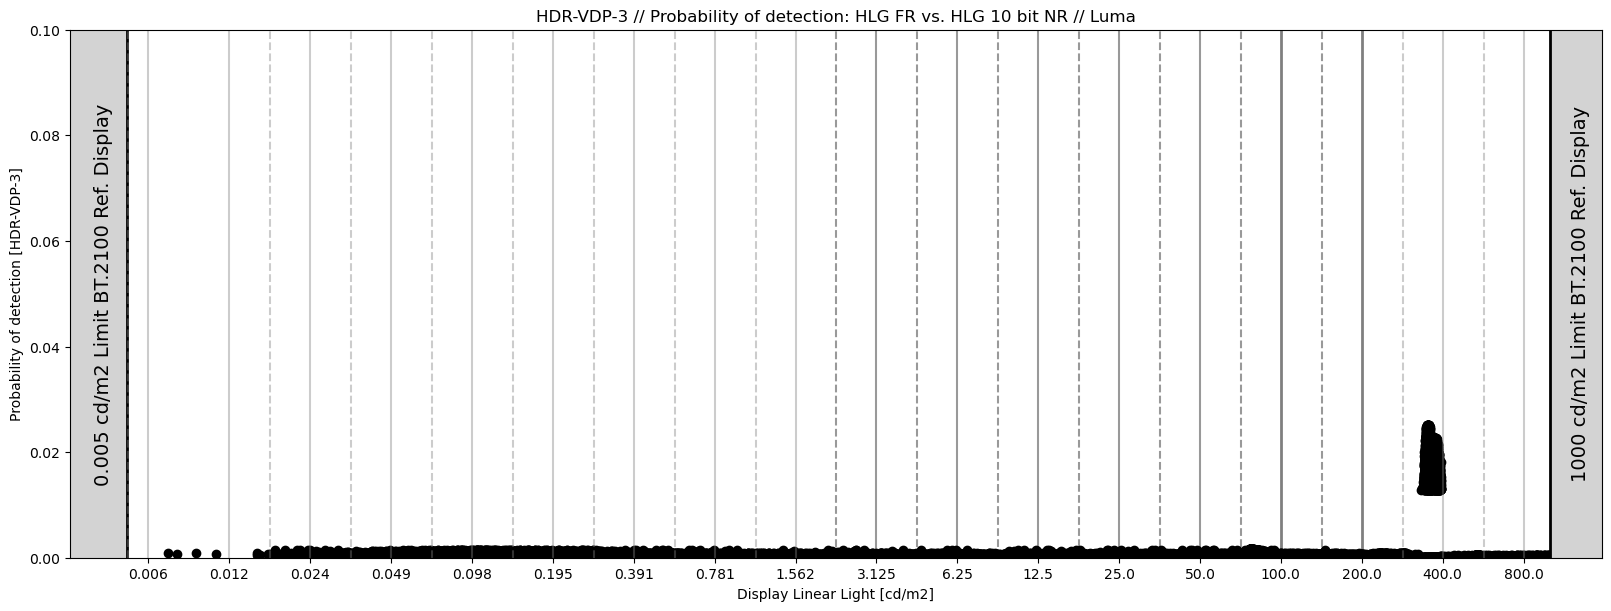

In [479]:
figR, (axL1) = plt.subplots(1, 1, figsize=(16, 6), constrained_layout=True)


# value_counter_image_hlg_FR = np.zeros((36))
# value_counter_image_pq_FR = np.zeros((36))

axL1.set_ylabel('Probability of detection [HDR-VDP-3]')
axL1.set_xlabel('Display Linear Light [cd/m2]')

# #x1 = np.linspace(0.000000000000001,1,1000000)

axL1.vlines(0.125/2/2/2/2/2/2+(0.125/2/2/2/2/2/2/3*2),0,10000000,color='black', linestyle="solid", alpha=1,linewidth=2)
axL1.vlines(0.125/2/2/2/2/2,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.125/2/2/2/2,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.125/2/2/2,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.125/2/2,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.125/2,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.125,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.25,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(0.5,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(1,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(2,0,10000000,color='black', linestyle="solid", alpha=0.4)
axL1.vlines(4,0,10000000,color='black', linestyle="solid", alpha=0.4)
axL1.vlines(8,0,10000000,color='black', linestyle="solid", alpha=0.4)
axL1.vlines(16,0,10000000,color='black', linestyle="solid", alpha=0.4)
axL1.vlines(32,0,10000000,color='black', linestyle="solid", alpha=0.4)
axL1.vlines(64,0,10000000,color='black', linestyle="solid", alpha=0.5, linewidth=2)
axL1.vlines(128,0,10000000,color='black', linestyle="solid", alpha=0.5, linewidth=2)
axL1.vlines(256,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(512,0,10000000,color='gray', linestyle="solid", alpha=0.4)
axL1.vlines(512+128,0,10000000,color='black', linestyle="solid", alpha=1, linewidth=2)



axL1.vlines(0.125/2/2/2/2-(0.125/3.45/2/2/2),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(0.125/2/2/2-(0.125/3.45/2/2/2),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(0.125/2/2-(0.125/3.45/2/2),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(0.125/2-(0.125/3.45/2),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(0.125-(0.125/3.45),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(0.25-(0.25/3.45),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(0.5-(0.5/3.45),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(1-(1/3.45),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(2-(2/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(4-(4/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(8-(8/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(16-(16/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(32-(32/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(64-(64/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(128-(128/3.45),0,10000000,color='black', linestyle="dashed", alpha=0.4)
axL1.vlines(256-(256/3.45),0,10000000,color='gray', linestyle="dashed", alpha=0.4)
axL1.vlines(512-(512/3.45),0,10000000,color='gray', linestyle="dashed", alpha=0.4)

axL1.hlines(1,0,1000000,color='red', linestyle="dashed", alpha=0.4)


x_array = np.array(HLG_PQ_ICtCp_Dict_i_values, dtype=np.float64)
y_array = np.array(HLG_PQ_ICtCp_Dict_e_keys, dtype=np.float64)

# Get indices to sort x_array in descending order
sorted_indices = np.argsort(y_array, kind='mergesort')[::-1]

# Sort both x_array and y_array based on the indices
sorted_x = x_array[sorted_indices]
sorted_y = y_array[sorted_indices]

# Keep only the top 2000 values
top_2000_x = sorted_x[:2000000]
top_2000_y = sorted_y[:2000000]

x_values_scale = c.models.eotf_ST2084(top_2000_x)

threshold = 0.0

filtered_y_values = [value for value, position in zip(top_2000_y, x_values_scale) if value >= threshold]
filtered_x_values = [position for value, position in zip(top_2000_y, x_values_scale) if value >= threshold]


# bars = ('A', 'B', 'C', 'D', 'E',
#     'F','G', 'H', 'I', 'J', 
#     'K','L','M', 'N', 'O', 
#     'P', 'Q','R','A', 'B', 
#     'C', 'D', 'E','F','G', 
#     'H', 'I', 'J', 'K','L',
#     'M', 'N', 'O', 'P', 'Q' , 'R')

# y_pos = np.arange(len(bars))

axL1.scatter(filtered_x_values,filtered_y_values,color="black")


# y_pos_between = np.round([200 * 2 ** i for i in range(-15,3)],3)
# y_pos_neu = np.linspace(0,17,18)

# axL1.set_xticks(y_pos_neu+1.5, y_pos_between)

axL1.set_xscale('log', base=2)

axL1.set_xlim(0.002,1000)
#axL1.set_yscale("log")
axL1.set_ylim(0,0.1)
xtickers = np.round([2**-14*100,2**-13*100,2**-12*100,2**-11*100,2**-10*100,2**-9*100,2**-8*100,2**-7*100,2**-6*100,2**-5*100,2**-4*100,2**-3*100,2**-2*100,2**-1*100,2**0*100,2**1*100,2**2*100,2**3*100],3)
axL1.set_xticks([2**-8,2**-7,2**-6,2**-5,2**-4,2**-3,2**-2,2**-1,2**0,2**1,2**2,2**3,2**4,2**5,2**6,2**7,2**8,2**9],xtickers[:])

# y_pos_between = np.round([200 * 2 ** i for i in range(-15,3)],3)
# y_pos_neu = np.linspace(0,17,18)

axL1.add_patch(Rectangle((0.125/2/2/2/2/2/2+0.0013, 0), -100, 10000000,facecolor = 'lightgray',fill=True,alpha=1))
axL1.add_patch(Rectangle((512+128, 0), 10000, 10000000,facecolor = 'lightgray',fill=True,alpha=1))

axL1.set_title("HDR-VDP-3 // Probability of detection: HLG FR vs. HLG 10 bit NR // Luma")

axL1.text(0.125/2/2/2/2/2/2+0.0007,0.05,"0.005 cd/m2 Limit BT.2100 Ref. Display",rotation=90,horizontalalignment="center",verticalalignment="center",fontsize=14)
axL1.text(512+256+64,0.05,"1000 cd/m2 Limit BT.2100 Ref. Display",rotation=90,horizontalalignment="center",verticalalignment="center",fontsize=14)


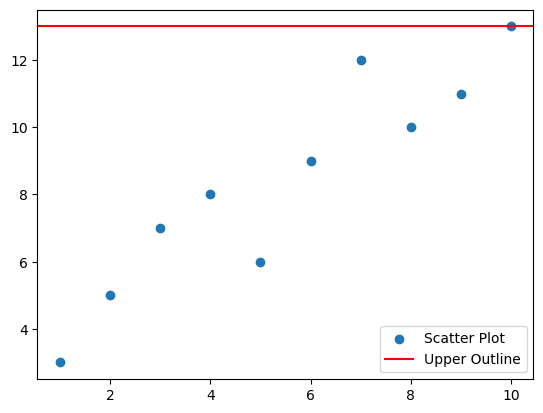

In [441]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have x and y coordinates of your scatter plot
# Replace these with your actual data
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y = [3, 5, 7, 8, 6, 9, 12, 10, 11, 13]

# Find the index of the maximum y value
highest_index = np.argmax(y)

# Extract the coordinates of the highest point
highest_point = np.array([x[highest_index], y[highest_index]])

# Plot the scatter plot
plt.scatter(x, y, label='Scatter Plot')

# Plot the upper outline as a line (horizontal line at the maximum y-coordinate)
plt.axhline(y=highest_point[1], color='r', linestyle='-', label='Upper Outline')

plt.legend()
plt.show()


In [184]:
print(HLG_PQ_ICtCp_Dict_cp_values[0:10])

[-0.092009771223883027, -0.10481947625904929, -0.091887246874245557, -0.096948045905053862, -0.056911882716635699, -0.057035442736787359, -0.096918756889751573, -0.098817463624803092, -0.10825115056356495, -0.095317654985811753]


In [185]:
print(HLG_PQ_ICtCp_Dict_ct_values[0:10])

[-0.0021679866666184933, 0.0091457137390137389, -0.010760207058327753, 0.010494587113532183, -0.0022455287609577379, -0.0015586925943935626, 0.02017715294039546, -0.0079742380276315306, 0.013101740012313901, 0.0071589453598199793]


In [188]:
len(HLG_PQ_ICtCp_Dict_i_values)

440000

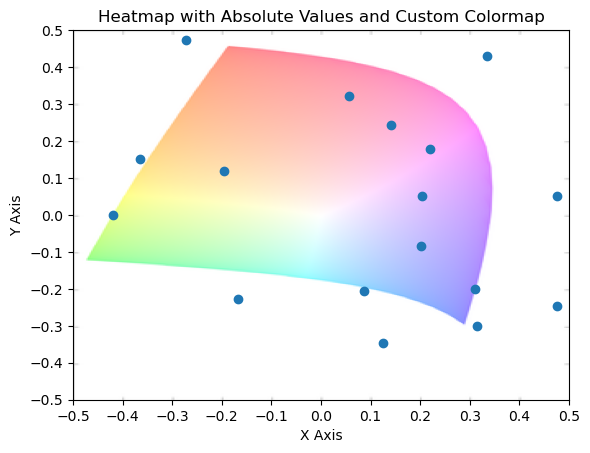

In [305]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots()

# Take the absolute values
x_array = np.array(HLG_PQ_ICtCp_Dict_ct_values, dtype=np.float64)
y_array = np.array(HLG_PQ_ICtCp_Dict_cp_values, dtype=np.float64)
Y_array = np.array(HLG_PQ_ICtCp_Dict_e_keys, dtype=np.float64)

values_array_abs = np.clip(Y_array, 0, 1)
ax.scatter(x_array,y_array)

# Set labels and title
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_title('Heatmap with Absolute Values and Custom Colormap')

# Add markers on x and y axes
x_ticks = np.arange(-0.5, 0.6, 0.1)
y_ticks = np.arange(-0.5, 0.6, 0.1)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)

# Load and display an image as the background
img_bg = plt.imread('/Users/justus/Desktop/ICtCp_top_view.png')
ax.imshow(img_bg[39:342,107:410,:], extent=[-0.5, 0.5, -0.5, 0.5], aspect='auto', alpha=0.5)

plt.show()


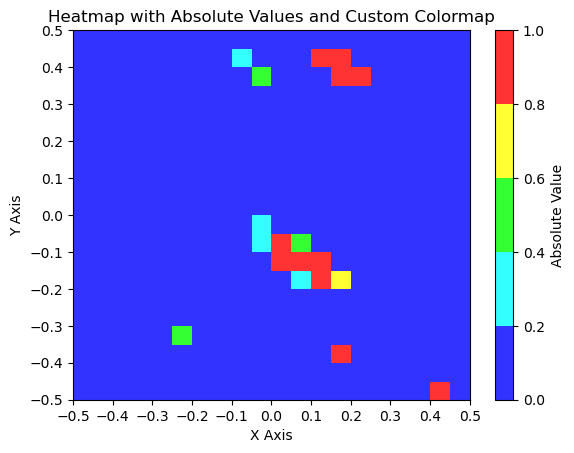

In [325]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Take the absolute values
x_array = np.array(HLG_PQ_ICtCp_Dict_ct_values, dtype=np.float64)
y_array = np.array(HLG_PQ_ICtCp_Dict_cp_values, dtype=np.float64)
Y_array = np.array(HLG_PQ_ICtCp_Dict_e_keys, dtype=np.float64)

values_array_abs = np.clip(Y_array, 0, 1)




# Define the number of bins for the x and y axes
num_bins = 20

# Create a 2D histogram to find the maximum value in each bin
heatmap, xedges, yedges = np.histogram2d(x_array, y_array, bins=num_bins, weights=values_array_abs, normed=False)

# Define custom colormap
colors = [
    [0.2, 0.2, 1.0],    # [0, 0.125)
    [0.2, 1.0, 1.0],    # [0.125, 0.325)
    [0.2, 1.0, 0.2],    # [0.325, 0.625)
    [1.0, 1.0, 0.2],    # [0.625, 0.875)
    [1.0, 0.2, 0.2]     # [0.875, 1]
]

custom_cmap = ListedColormap(colors)

# Plot the heatmap with the custom colormap
plt.imshow(heatmap.T, extent=[-0.5, 0.5, -0.5, 0.5],
           origin='lower', aspect='auto', vmin=0, vmax=1, cmap=custom_cmap)

# Add colorbar
plt.colorbar(label='Absolute Value')

# Set labels and title
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('Heatmap with Absolute Values and Custom Colormap')

# Add markers on x and y axes
x_ticks = np.arange(-0.5, 0.6, 0.1)
y_ticks = np.arange(-0.5, 0.6, 0.1)
plt.xticks(x_ticks)
plt.yticks(y_ticks)

# Show the plot
plt.show()


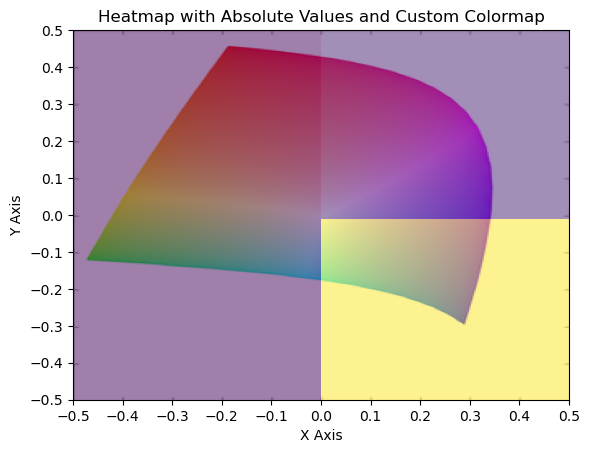

In [326]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Take the absolute values
x_array = np.array(HLG_PQ_ICtCp_Dict_ct_values, dtype=np.float64)
y_array = np.array(HLG_PQ_ICtCp_Dict_cp_values, dtype=np.float64)
Y_array = np.array(HLG_PQ_ICtCp_Dict_e_keys, dtype=np.float64)

values_array_abs = np.clip(Y_array, 0, 1)

x_data = x_array
y_data = y_array
value_data = Y_array


# Define the bin size
bin_size = 5

# Create 2D histogram with specified bins
hist, x_edges, y_edges = np.histogram2d(x_data, y_data, bins=[np.arange(-50, 51, bin_size), np.arange(-50, 51, bin_size)])

# Initialize an array to store the maximum values for each bin
max_values = np.zeros_like(hist)

# Iterate through each bin and find the maximum value
for i in range(len(x_edges) - 1):
    for j in range(len(y_edges) - 1):
        x_bin_range = (x_edges[i], x_edges[i + 1])
        y_bin_range = (y_edges[j], y_edges[j + 1])

        # Mask data within the current bin
        mask = (x_data >= x_bin_range[0]) & (x_data < x_bin_range[1]) & (y_data >= y_bin_range[0]) & (y_data < y_bin_range[1])

        # Check if the bin is not empty
        if np.sum(mask) > 0:
            # Get the maximum value within the bin
            max_value = np.max(value_data[mask])

            # Store the maximum value in the corresponding position in the array
            max_values[i, j] = max_value

# Create a heatmap using Matplotlib
plt.imshow(max_values, cmap='viridis', extent=[-50, 50, -50, 50], origin='lower')


# Set labels and title
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_title('Heatmap with Absolute Values and Custom Colormap')

# Add markers on x and y axes
x_ticks = np.arange(-0.5, 0.6, 0.1)
y_ticks = np.arange(-0.5, 0.6, 0.1)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)

# Load and display an image as the background
img_bg = plt.imread('/Users/justus/Desktop/ICtCp_top_view.png')
ax.imshow(img_bg[39:342,107:410,:], extent=[-0.5, 0.5, -0.5, 0.5], aspect='auto', alpha=0.5)




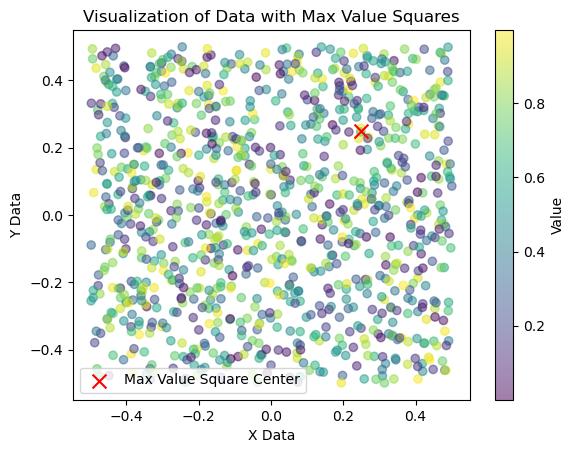

In [329]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data
x_data = np.random.uniform(-0.5, 0.5, size=1000)
y_data = np.random.uniform(-0.5, 0.5, size=1000)
value_data = np.random.rand(1000)  # Replace this with your actual value data

# Define parameters
grid_size = 0.25  # Size of each square
x_bins = np.arange(-0.5, 0.6, grid_size)
y_bins = np.arange(-0.5, 0.6, grid_size)

# Create a 2D histogram to calculate the max value in each square
hist, x_edges, y_edges = np.histogram2d(x_data, y_data, bins=[x_bins, y_bins], weights=value_data, normed=False)

# Get the coordinates of the maximum value in each square
x_max, y_max = np.unravel_index(np.argmax(hist, axis=None), hist.shape)

# Plot the data
plt.scatter(x_data, y_data, c=value_data, cmap='viridis', marker='o', alpha=0.5)
plt.colorbar(label='Value')
plt.scatter(x_edges[x_max], y_edges[y_max], marker='x', color='red', s=100, label='Max Value Square Center')
plt.legend()
plt.xlabel('X Data')
plt.ylabel('Y Data')
plt.title('Visualization of Data with Max Value Squares')
plt.show()


In [480]:
import numpy as np



# Sample data
x_data = np.array(HLG_PQ_ICtCp_Dict_ct_values, dtype=np.float64)
y_data = np.array(HLG_PQ_ICtCp_Dict_cp_values, dtype=np.float64)
values = np.array(HLG_PQ_ICtCp_Dict_e_keys, dtype=np.float64)

# Define grid parameters
grid_size = 0.1/2
grid_range = np.arange(-0.5, 0.6, grid_size)

# Initialize maximum value array
max_values = np.zeros((len(grid_range), len(grid_range)))

# Iterate over the grid
for i, x_center in enumerate(grid_range):
    for j, y_center in enumerate(grid_range):
        # Define square boundaries
        x_min, x_max = x_center - 0.5 * grid_size, x_center + 0.5 * grid_size
        y_min, y_max = y_center - 0.5 * grid_size, y_center + 0.5 * grid_size

        # Find indices within the square
        indices = np.where((x_data >= x_min) & (x_data <= x_max) & (y_data >= y_min) & (y_data <= y_max))[0]

        # Find maximum value within the square
        if len(indices) > 0:
            max_values[i, j] = np.max(values[indices])

# Print the result
print("Maximum values within each square:")
print(max_values)
print(np.shape(max_values))

Maximum values within each square:
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    3.70000000e-05   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   4.40000000e-05
    4.30000000e-05   0.00000000e+00   0.00000000e+0

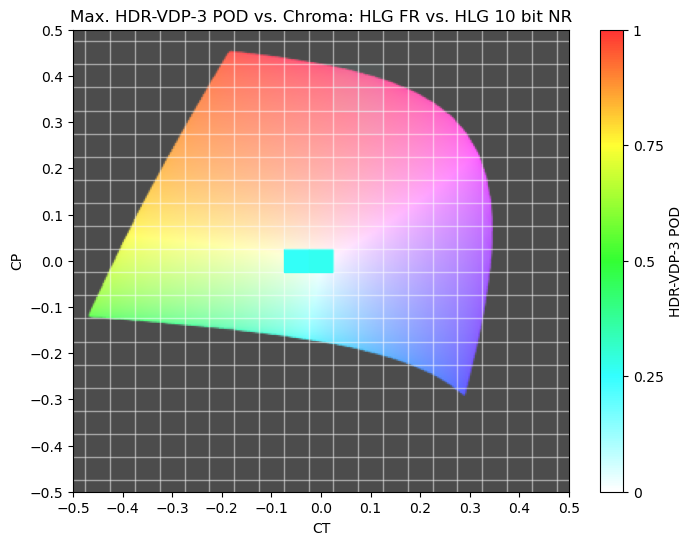

In [482]:
import numpy as np
import matplotlib.pyplot as plt

# Sample 2D array (replace this with your actual data)
data = max_values

# Define grid parameters
grid_size = 0.1/2
grid_range = np.arange(-0.5, 0.6, grid_size)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Define your custom colors and their positions
colors = [
    (1, 1, 1,0.3),          # Black at 0
    (0.2, 1, 1, 1),        # Light blue
    (0.2, 1, 0.2,1),      # Light green
    (1, 1, 0.2,1),        # Light yellow
    (1, 0.2, 0.2,1),      # Light red
]
positions = [0, 0.25, 0.5, 0.75, 1]

# Create a LinearSegmentedColormap with custom colors and positions
custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', list(zip(positions, colors)))


threshold = -1.000


# Iterate over the grid
for i, x_center in enumerate(grid_range):
    for j, y_center in enumerate(grid_range):
        # Define square boundaries
        x_min, x_max = x_center - 0.5 * grid_size, x_center + 0.5 * grid_size
        y_min, y_max = y_center - 0.5 * grid_size, y_center + 0.5 * grid_size

        # Check if data value is larger than the threshold
        if data[i, j] > threshold:
            # Plot square with transparency representing the data value
            square = plt.Rectangle((x_min, y_min), grid_size, grid_size, fill=True, color=custom_cmap(data[i, j]))
            ax.add_patch(square)


# Set plot limits
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)

# Set axis labels
ax.set_title('Max. HDR-VDP-3 POD vs. Chroma: HLG FR vs. HLG 10 bit NR')
ax.set_xlabel('CT')
ax.set_ylabel('CP')

# Show colorbar for reference
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=custom_cmap))
cbar.set_label('HDR-VDP-3 POD')
cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])  # Set desired tick positions
cbar.set_ticklabels(['0', '0.25', '0.5', '0.75', '1'])  # Set desired tick labels


x_ticks = np.arange(-0.5, 0.6, 0.1)
y_ticks = np.arange(-0.5, 0.6, 0.1)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)

# Load and display an image as the background
img_bg = plt.imread('/Users/justus/Desktop/ICtCp_top_view2.png')
ax.imshow(img_bg[39:342,107:410,:], extent=[-0.5, 0.5, -0.5, 0.5], aspect='auto', alpha=1)

plt.show()



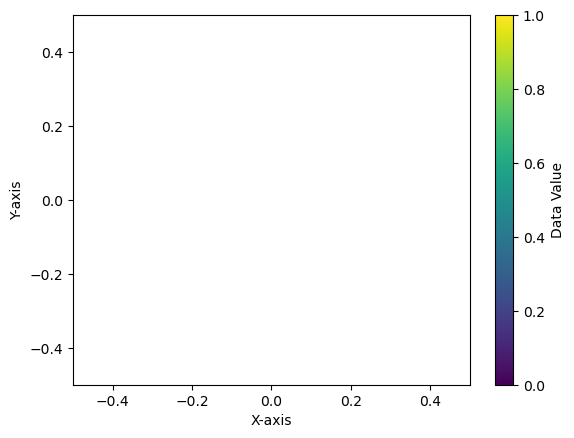

In [417]:
import numpy as np
import matplotlib.pyplot as plt

# Sample 2D array (replace this with your actual data)
data = max_values

# Define threshold for data value
threshold = 0.0001

# Define grid parameters
grid_size = 0.1
grid_range = np.arange(-0.5, 0.6, grid_size)

# Create a figure and axis
fig, ax = plt.subplots()

# Iterate over the grid
for i, x_center in enumerate(grid_range):
    for j, y_center in enumerate(grid_range):
        # Define square boundaries
        x_min, x_max = x_center - 0.5 * grid_size, x_center + 0.5 * grid_size
        y_min, y_max = y_center - 0.5 * grid_size, y_center + 0.5 * grid_size

        # Check if data value is larger than the threshold
        if data[i, j] > threshold:
            # Plot square with transparency representing the data value
            square = plt.Rectangle((x_min, y_min), grid_size, grid_size, fill=True, color=plt.cm.viridis(data[i, j]), alpha=0.7)
            ax.add_patch(square)

# Set plot limits
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)

# Set axis labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Show colorbar for reference
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.viridis))
cbar.set_label('Data Value')

# Show the plot
plt.show()


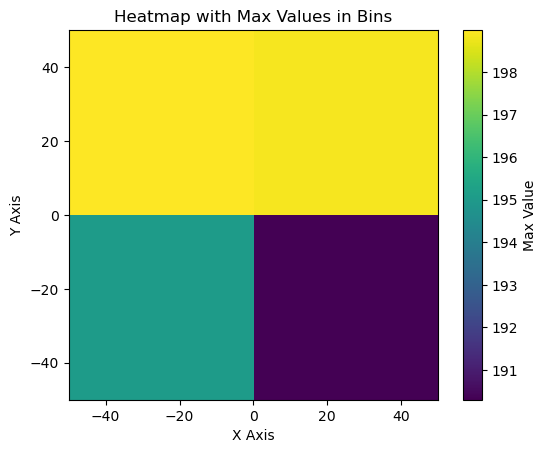

In [321]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data
x_data = np.random.uniform(low=-50, high=50, size=100)
y_data = np.random.uniform(low=-50, high=50, size=100)
value_data = np.random.rand(100) * 200

# Define the bin size
bin_size = 50

# Create 2D histogram with specified bins
hist, x_edges, y_edges = np.histogram2d(x_data, y_data, bins=[np.arange(-50, 51, bin_size), np.arange(-50, 51, bin_size)])

# Initialize an array to store the maximum values for each bin
max_values = np.zeros_like(hist)

# Iterate through each bin and find the maximum value
for i in range(len(x_edges) - 1):
    for j in range(len(y_edges) - 1):
        x_bin_range = (x_edges[i], x_edges[i + 1])
        y_bin_range = (y_edges[j], y_edges[j + 1])

        # Mask data within the current bin
        mask = (x_data >= x_bin_range[0]) & (x_data < x_bin_range[1]) & (y_data >= y_bin_range[0]) & (y_data < y_bin_range[1])

        # Check if the bin is not empty
        if np.sum(mask) > 0:
            # Get the maximum value within the bin
            max_value = np.max(value_data[mask])

            # Store the maximum value in the corresponding position in the array
            max_values[i, j] = max_value

# Create a heatmap using Matplotlib
plt.imshow(max_values, cmap='viridis', extent=[-50, 50, -50, 50], origin='lower')
plt.colorbar(label='Max Value')
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('Heatmap with Max Values in Bins')
plt.show()


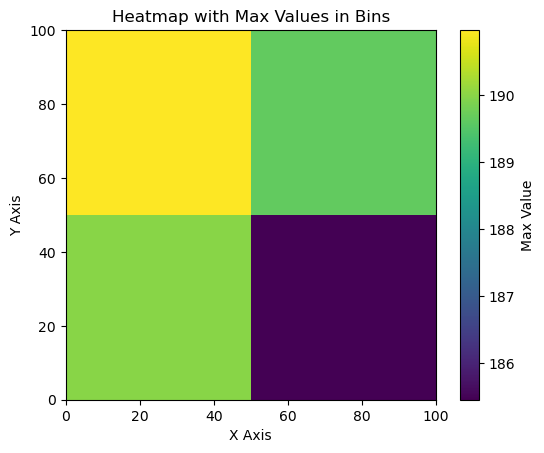

In [310]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data
x_data = np.random.rand(100) * 100
y_data = np.random.rand(100) * 100
value_data = np.random.rand(100) * 200

# Define the bin size
bin_size = 50

# Create 2D histogram with specified bins
hist, x_edges, y_edges = np.histogram2d(x_data, y_data, bins=[np.arange(0, 101, bin_size), np.arange(0, 101, bin_size)])

# Initialize an array to store the maximum values for each bin
max_values = np.zeros_like(hist)

# Iterate through each bin and find the maximum value
for i in range(len(x_edges) - 1):
    for j in range(len(y_edges) - 1):
        x_bin_range = (x_edges[i], x_edges[i + 1])
        y_bin_range = (y_edges[j], y_edges[j + 1])

        # Mask data within the current bin
        mask = (x_data >= x_bin_range[0]) & (x_data < x_bin_range[1]) & (y_data >= y_bin_range[0]) & (y_data < y_bin_range[1])

        # Get the maximum value within the bin
        max_value = np.max(value_data[mask])

        # Store the maximum value in the corresponding position in the array
        max_values[i, j] = max_value

# Create a heatmap using Matplotlib
plt.imshow(max_values, cmap='viridis', extent=[0, 100, 0, 100], origin='lower')
plt.colorbar(label='Max Value')
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('Heatmap with Max Values in Bins')
plt.show()


In [314]:
len(value_data)

100

In [ ]:
# Define the bin size
bin_size = 50

# Create 2D histogram with specified bins
hist, x_edges, y_edges = np.histogram2d(x_data, y_data, bins=[np.arange(0, 101, bin_size), np.arange(0, 101, bin_size)])

# Initialize an array to store the maximum values for each bin
max_values = np.zeros_like(hist)

# Iterate through each bin and find the maximum value
for i in range(len(x_edges) - 1):
    for j in range(len(y_edges) - 1):
        x_bin_range = (x_edges[i], x_edges[i + 1])
        y_bin_range = (y_edges[j], y_edges[j + 1])

        # Mask data within the current bin
        mask = (x_data >= x_bin_range[0]) & (x_data < x_bin_range[1]) & (y_data >= y_bin_range[0]) & (y_data < y_bin_range[1])

        # Get the maximum value within the bin
        max_value = np.max(value_data[mask])

        # Store the maximum value in the corresponding position in the array
        max_values[i, j] = max_value

# Create a heatmap using Matplotlib
plt.imshow(max_values, cmap='viridis', extent=[0, 100, 0, 100], origin='lower')

In [84]:
import numpy as np

# Assuming you have two arrays: x_array and y_array
x_array = np.array(HLG_PQ_ICtCp_Dict_cp_keys, dtype=np.float64)
y_array = np.array(HLG_PQ_ICtCp_Dict_cp_values, dtype=np.float64)
y_array = abs(y_array)

# Get indices to sort x_array in descending order
sorted_indices = np.argsort(y_array, kind='mergesort')[::-1]

# Sort both x_array and y_array based on the indices
sorted_x = x_array[sorted_indices]
sorted_y = y_array[sorted_indices]

# Keep only the top 2000 values
top_2000_x = sorted_x[:2000]
top_2000_y = sorted_y[:2000]

print(top_2000_x)
print(top_2000_y)


[-0.02426642 -0.02463381 -0.02323792 ...,  0.27616252  0.30901179
  0.28112185]
[ 0.054903  0.045541  0.039295 ...,  0.004266  0.004265  0.004264]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Assuming you have three arrays: x_array, y_array, and values_array
x_array = np.random.rand(100) - 0.5  # Replace with your actual x values
y_array = np.random.rand(100) - 0.5  # Replace with your actual y values
values_array = np.random.rand(100)  # Replace with your actual values

# Take the absolute values
values_array_abs = np.abs(values_array)

# Define the number of bins for the x and y axes
num_bins = 20

# Create a 2D histogram to find the maximum value in each bin
heatmap, xedges, yedges = np.histogram2d(x_array, y_array, bins=num_bins, weights=values_array_abs, normed=False)

# Define custom colormap
colors = [
    [0.2, 0.2, 1.0],    # [0, 0.125)
    [0.2, 1.0, 1.0],    # [0.125, 0.325)
    [0.2, 1.0, 0.2],    # [0.325, 0.625)
    [1.0, 1.0, 0.2],    # [0.625, 0.875)
    [1.0, 0.2, 0.2]     # [0.875, 1]
]

custom_cmap = ListedColormap(colors)

# Plot the heatmap with the custom colormap
plt.imshow(heatmap.T, extent=[-0.5, 0.5, -0.5, 0.5],
           origin='lower', aspect='auto', vmin=0, vmax=1, cmap=custom_cmap)

# Add colorbar
plt.colorbar(label='Absolute Value')

# Set labels and title
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('Heatmap with Absolute Values and Custom Colormap')

# Add markers on x and y axes
x_ticks = np.arange(-0.5, 0.6, 0.1)
y_ticks = np.arange(-0.5, 0.6, 0.1)
plt.xticks(x_ticks)
plt.yticks(y_ticks)

# Show the plot
plt.show()


[(0.74752710915336673, '0.045541'), (0.74633352331399516, '0.039295'), (0.74647141903026015, '0.031231'), (0.73954068654169758, '0.028802'), (0.74409667628610943, '0.028063'), (0.5905710164614002, '0.024855'), (0.59067105905140527, '0.024517'), (0.58980909745462173, '0.023226'), (0.59018648615757319, '0.022406'), (0.59837716669525642, '0.022041'), (0.59780720913718188, '0.021238'), (0.59463363824881532, '0.021082'), (0.59787792063868461, '0.020384'), (0.59816225889726748, '0.019998'), (0.59895661246010778, '0.019881'), (0.59965691249963582, '0.019507'), (0.58833947333168846, '0.019158'), (0.60033571278200815, '0.018718'), (0.58944601746810443, '0.018622'), (0.60025703156123433, '0.018094'), (0.59735344307895988, '0.018092'), (0.5899930578955016, '0.018054'), (0.59257282064151362, '0.017920'), (0.60280107964120111, '0.017792'), (0.74418819376138079, '0.017538'), (0.59026262776584271, '0.017455'), (0.74414229766593976, '0.017303'), (0.60087113330201392, '0.017123'), (0.60098711464301902,

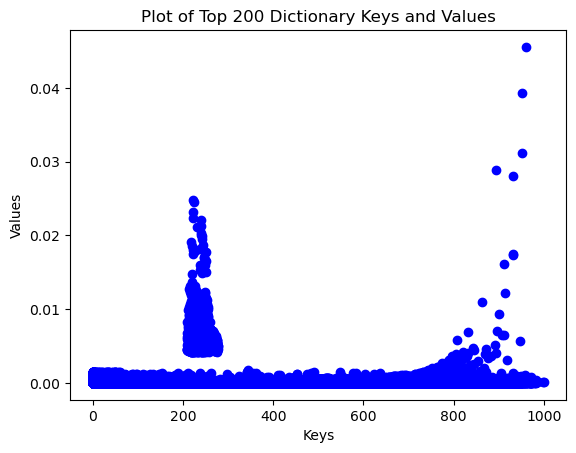

In [26]:
sorted_items = sorted(HLG_PQ_ICtCp_Dict_i.items(), key=lambda x: x[1], reverse=True)
top_items = sorted_items[:20000000]
print(top_items)
x_values, y_values = zip(*top_items)
y_values_float = [float(value) for value in y_values]
x_values_scale = c.models.eotf_ST2084(x_values)

threshold = 0

filtered_y_values = [value for value, position in zip(y_values_float, x_values_scale) if value > threshold]
filtered_x_values = [position for value, position in zip(y_values_float, x_values_scale) if value > threshold]


print(y_values_float)
# Plot the data
plt.scatter(filtered_x_values, filtered_y_values, marker='o', linestyle='-', color='b')
plt.xlabel('Keys')
plt.ylabel('Values')
plt.title('Plot of Top 200 Dictionary Keys and Values')
plt.show()

In [ ]:
sorted_items = sorted(HLG_PQ_ICtCp_Dict_i.items(), key=lambda x: x[1], reverse=True)
top_items = sorted_items[:2000000]
print(top_items)
x_values, y_values = zip(*top_items)
y_values_float = [float(value) for value in y_values]
x_values_scale = c.models.eotf_ST2084(x_values)

threshold = 0

filtered_y_values = [value for value, position in zip(y_values_float, x_values_scale) if value > threshold]
filtered_x_values = [position for value, position in zip(y_values_float, x_values_scale) if value > threshold]


print(y_values_float)
# Plot the data
plt.scatter(filtered_x_values, filtered_y_values, marker='o', linestyle='-', color='b')
plt.xlabel('Keys')
plt.ylabel('Values')
plt.title('Plot of Top 200 Dictionary Keys and Values')
plt.show()

In [ ]:
import numpy as np

def flatten_and_reshape_array(original_array, new_shape):
    flattened_array = np.array(original_array).flatten()
    reshaped_array = flattened_array[:np.prod(new_shape)].reshape(new_shape)
    return reshaped_array

# Create a sample 2D array
sample_2d_array = np.random.randint(1, 10, size=(8, 10))

# Specify the new shape (for example, 4x20)
new_shape = (4, 20)

# Flatten and reshape the array
result_array = flatten_and_reshape_array(sample_2d_array, new_shape)

# Print the original and resulting reshaped array
print("Original 2D Array:")
print(sample_2d_array)
print("\nFlattened and Reshaped Array:")
print(result_array)


In [10]:
new_shape = (2160,3840)
result_array = flatten_and_reshape_array(image_csv, new_shape)

In [11]:
print(result_array[0,0:10])

['-0.000023' '-0.000024' '-0.000025' '-0.000025' '-0.000026' '-0.000027'
 '-0.000028' '-0.000029' '-0.000030' '-0.000031']


In [4]:
legal2full(940)

1.0

In [9]:
import numpy as np

def flatten_and_reshape_array(original_array, new_shape):
    flattened_array = np.array(original_array).flatten()
    reshaped_array = flattened_array[:np.prod(new_shape)].reshape(new_shape)
    return reshaped_array

# Create a sample 2D array
sample_2d_array = np.random.randint(1, 10, size=(8, 10))

# Specify the new shape (for example, 4x20)
new_shape = (4, 20)

# Flatten and reshape the array
result_array = flatten_and_reshape_array(sample_2d_array, new_shape)

# Print the original and resulting reshaped array
print("Original 2D Array:")
print(sample_2d_array)
print("\nFlattened and Reshaped Array:")
print(result_array)


Original 2D Array:
[[3 3 6 4 8 9 4 4 5 4]
 [6 5 2 4 9 7 5 4 3 2]
 [1 4 1 5 3 3 8 2 4 4]
 [2 5 4 6 5 8 3 7 8 6]
 [4 9 1 5 3 1 6 5 6 2]
 [6 9 8 7 1 7 5 2 4 4]
 [1 7 6 5 4 5 7 6 9 5]
 [3 5 4 8 7 5 8 8 8 8]]

Flattened and Reshaped Array:
[[3 3 6 4 8 9 4 4 5 4 6 5 2 4 9 7 5 4 3 2]
 [1 4 1 5 3 3 8 2 4 4 2 5 4 6 5 8 3 7 8 6]
 [4 9 1 5 3 1 6 5 6 2 6 9 8 7 1 7 5 2 4 4]
 [1 7 6 5 4 5 7 6 9 5 3 5 4 8 7 5 8 8 8 8]]


# Source Comp HLG and PQ

In [186]:
test_pq = c.read_image("/Users/justus/Library/CloudStorage/SynologyDrive-DriveJustus/HdM/AM3_4/Masterarbeit/Neuer_Vergleich/TRANSFORMED_PQ_BT2020_FR_UHD_F002C012_220412_R07V.01119678.tif")
test_hlg = c.read_image("/Users/justus/Library/CloudStorage/SynologyDrive-DriveJustus/HdM/AM3_4/Masterarbeit/Neuer_Vergleich/TRANSFORMED_HLG_BT2020_FR_UHD_F002C012_220412_R07V.01119678.tif")

KeyboardInterrupt: 

In [229]:
test_pq = c.read_image("/Volumes/T7_Shield/11_Source_Content/11.1_TRANSFORMED_PQ_FR_UHD/ARRI_Encounters/2_B002C016_220405_B09C/TRANSFORMED_PQ_BT2020_FR_UHD_B002C016_220405_B09C.01513213.tif")
test_hlg = c.read_image("/Volumes/T7_Shield/11_Source_Content/12.1_TRANSFORMED_HLG_FR_UHD/ARRI_Encounters/2_B002C016_220405_B09C/TRANSFORMED_HLG_BT2020_FR_UHD_B002C016_220405_B09C.01513213.tif")

In [218]:
test_pq2 = c.read_image("/Volumes/JM_SSD/11.1_Source_Content_Scaled/PQ_UHD/11.1_TRANSFORMED_PQ_FR_UHD/ARRI_Encounters/2_B002C016_220405_B09C/TRANSFORMED_PQ_BT2020_FR_UHD_B002C016_220405_B09C.00000000.tif")

In [223]:
import cv2
import numpy as np

def find_biggest_difference(image1, image2):
    # Convert images to grayscale
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Compute absolute difference
    diff = cv2.absdiff(gray1, gray2)

    # Find the location of the maximum difference
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(diff)

    return max_loc, max_val

# Load your two images
image1 = cv2.imread('/Volumes/T7_Shield/11_Source_Content/11.1_TRANSFORMED_PQ_FR_UHD/ARRI_Encounters/2_B002C016_220405_B09C/TRANSFORMED_PQ_BT2020_FR_UHD_B002C016_220405_B09C.01513213.tif')
image2 = cv2.imread('/Volumes/T7_Shield/11_Source_Content/12.1_TRANSFORMED_HLG_FR_UHD/ARRI_Encounters/2_B002C016_220405_B09C/TRANSFORMED_HLG_BT2020_FR_UHD_B002C016_220405_B09C.01513213.tif')

# Find the biggest difference
location, value = find_biggest_difference(image1, image2)

print(f"The biggest difference is at location {location} with a value of {value}.")


[ WARN:0@36397.969] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/grfmt_tiff.cpp (629) readData OpenCV TIFF: TIFFRGBAImageOK: Sorry, can not handle images with 32-bit samples
[ WARN:0@36397.977] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/grfmt_tiff.cpp (629) readData OpenCV TIFF: TIFFRGBAImageOK: Sorry, can not handle images with 32-bit samples


error: OpenCV(4.6.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [230]:
test_pq_linear = c.models.eotf_ST2084(test_pq)
test_hlg_linear = c.models.eotf_HLG_BT2100(test_hlg,0,1000)

In [226]:
test_pq2_linear = c.models.eotf_ST2084(test_pq2)

In [189]:
np.max(test_hlg_linear)

999.97327860472535

In [195]:
np.max(test_pq2_linear)

1000.0013186303987

### Difference

In [231]:
diff = np.subtract(test_hlg_linear,test_pq_linear)

In [258]:
max_index = np.argmin(test_pq_linear.flatten())

In [259]:
print(max_index)

23026895


In [261]:
diff.flatten()[23026895]

-4.9489488462145514e-11

In [260]:
test_hlg_linear.flatten()[23026895]

0.00070534648489616514

In [233]:
np.min(diff)

-0.00046220837737109832

### Level 1 Encoded

In [164]:
test_pq_encoded = c.read_image("/Users/justus/Library/CloudStorage/SynologyDrive-DriveJustus/HdM/AM3_4/Masterarbeit/Neuer_Vergleich/04_Test_PQ180014.tif")
test_hlg_encoded = c.read_image("/Users/justus/Library/CloudStorage/SynologyDrive-DriveJustus/HdM/AM3_4/Masterarbeit/Neuer_Vergleich/04_Test_HLG180014.tif")

In [166]:
np.max(test_hlg_encoded)

1.0

In [167]:
test_pq_linear_encoded = c.models.eotf_ST2084(test_pq_encoded)
test_hlg_linear_encoded = c.models.eotf_HLG_BT2100(test_hlg_encoded,0,1000)

In [168]:
np.max(test_hlg_linear_encoded)

1000.0000323217691

In [169]:
np.max(test_pq_linear_encoded)

1093.3912674700073

In [170]:
diff_encoded = np.subtract(test_pq_linear_encoded,test_hlg_linear_encoded)

In [171]:
np.max(diff_encoded)

163.5117716720415